<a href="https://colab.research.google.com/github/Zuyuf/Machine_Learning_Specialization/blob/main/2%20-%20Machine%20Learning%20-%20Regression/Week%204%20-%20Ridge%20Regression/3_Gradient_Decent_Ridge_Regression_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install turicreate

     |████████████████████████████████| 91.9MB 29kB/s 
     |████████████████████████████████| 2.1MB 42.2MB/s 
     |████████████████████████████████| 86.3MB 49kB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
     |████████████████████████████████| 3.4MB 26.4MB/s 
     |████████████████████████████████| 3.8MB 54.1MB/s 
     |████████████████████████████████| 450kB 48.2MB/s 
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.4.0 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0
  Found existing installation: google-auth-oauthlib 0.4.0
    Uninstalling google-auth-oauthlib-0.4.0:
      Successfully uninstalled google-auth-oauthlib-0.4.0
  Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensor

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import turicreate as tc
from collections import defaultdict
from turicreate.toolkits._internal_utils import _raise_error_if_column_exists
from turicreate.toolkits._main import ToolkitError


def _get_classification_metrics(model, targets, predictions):
    """
    Parameters
    ----------
    model: Classifier
        Turi create trained classifier.
    targets: SArray
        Array containing the expected labels.
    predictions: SArray
        Array containing the predicted labels.
    Returns
    -------
    dict
        An average metrics of the n folds.
    """
    precision = tc.evaluation.precision(targets, predictions)
    accuracy = tc.evaluation.accuracy(targets, predictions)
    recall = tc.evaluation.recall(targets, predictions)
    auc = tc.evaluation.auc(targets, predictions)
    return {"recall": recall,
            "precision": precision,
            "accuracy": accuracy,
            "auc": auc
            }


def _kfold_sections(data, n_folds):
    """
    Calculate the indexes of the splits that should
    be used to split the data into n_folds.
    Parameters
    ----------
    data: SFrame
        A Non empty SFrame.
    n_folds: int
        The number of folds to create. Must be at least 2.
    Yields
    -------
    (int, int)
        Yields the first and last index of the fold.
    Notes
    -----
        Based on scikit implementation.
    """
    Neach_section, extras = divmod(len(data), n_folds)
    section_sizes = ([0] +
                     extras * [Neach_section + 1] +
                     (n_folds - extras) * [Neach_section])
    div_points = np.array(section_sizes).cumsum()
    for i in range(n_folds):
        st = div_points[i]
        end = div_points[i + 1]
        yield st, end


def shuffle_sframe(sf, random_seed=None, temp_shuffle_col="shuffle_col"):
    """
    Create a copy of the SFrame where the rows have been shuffled randomly.
    Parameters
    ----------
    sf: SFrame
        A Non empty SFrame.
    random_seed: int, optional
        Random seed to use for the randomization. If provided, each call
        to this method will produce an identical result.
    temp_shuffle_col: str, optional
        Change only if you use the same column name.
    Returns
    -------
    SFrame
        A randomly shuffled SFrame.
    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> shuffle_sframe(sf)
    """

    if temp_shuffle_col in sf.column_names():
        raise ToolkitError('The SFrame already contains column named {0}. '
                           'Please enter set another value to temp_shuffle_col'.format(temp_shuffle_col))
    shuffled_sframe = sf.copy()
    shuffled_sframe[temp_shuffle_col] = tc.SArray.random_integers(sf.num_rows(), random_seed)
    return shuffled_sframe.sort(temp_shuffle_col).remove_column(temp_shuffle_col)


def KFold(data, n_folds=10):
    """
    Create a K-Fold split of a data set as an iterable/indexable object of K pairs,
    where each pair is a partition of the dataset.  This can be useful for cross
    validation, where each fold is used as a held out dataset while training
    on the remaining data.
    Parameters
    ----------
    data: SFrame
        A Non empty SFrame.
    n_folds: int
        The number of folds to create. Must be at least 2.
    Notes
    -----
    This does not shuffle the data. Shuffling your data is a useful preprocessing step when doing cross validation.
    Yields
    -------
    (SArray, SArray)
        Yields train, test of each fold
    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> folds = KFold(sf)
    """
    if data.num_rows() < n_folds:
        raise ValueError
    for st, end in _kfold_sections(data, n_folds):
        idx = np.zeros(len(data))
        idx[st:end] = 1
        yield data[tc.SArray(1 - idx)], data[tc.SArray(idx)]


def StratifiedKFold(data, label='label', n_folds=10):
    """
    Create a Starified K-Fold split of a data set as an iteratable/indexable object
    of K pairs, where each pair is a partition of the data set. This can be useful
    for cross validation, where each fold is used as a heldout dataset while
    training on the remaining data. Unlike the regular KFold the folds are
    made by preserving the percentage of samples for each class.
    The StratifiedKFold is more suitable for smaller datasets
    or for datasets where there a is a minority class.
    Parameters
    ----------
    data: SFrame
        A Non empty SFrame.
    label: str
        The target/class column name in the SFrame.
    n_folds: int
        The number of folds to create. Must be at least 2.
    Notes
    -----
    This does not shuffle the data. Shuffling your data is a useful preprocessing step when doing cross validation.
    Yields
    -------
    (SArray, SArray)
        Yields train, test of each fold
    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> folds = StratifiedKFold(sf)
    """
    _raise_error_if_column_exists(data, label, 'data', label)

    labels = data[label].unique()
    labeled_data = [data[data[label] == l] for l in labels]
    fold = [KFold(item, n_folds) for item in labeled_data]
    for _ in range(n_folds):
        train, test = tc.SFrame(), tc.SFrame()
        for f in fold:
            x_train, x_test = f.next()
            train = train.append(x_train)
            test = test.append(x_test)
        yield train, test


def cross_val_score(datasets, model_factory, model_parameters=None, evaluator=_get_classification_metrics):
    """
    Evaluate model performance via cross validation for a given set of parameters.
    Parameters
    ----------
    datasets: iterable of tuples
        The data used to train the model on a format of iterable of tuples.
        The tuples should be in a format of (train, test).
    model_factory: function
        This is the function used to create the model.
        For example, to perform model_parameter_search using the
        GraphLab Create model graphlab.linear_regression.LinearRegression,
        the model_factory is graphlab.linear_regression.create().
    model_parameters: dict
        The params argument takes a dictionary containing parameters that will be passed to the provided model factory.
    evaluator: function (model, training_set, validation_set) -> dict, optional
        The evaluation function takes as input the model, training and validation SFrames,
        and returns a dictionary of evaluation metrics where each value is a simple type, e.g. float, str, or int.
    Returns
    -------
    dict
        The calculate metrics for the cross validation.
    Examples
    --------
        >>> url = 'https://static.turi.com/datasets/xgboost/mushroom.csv'
        >>> sf = tc.SFrame.read_csv(url)
        >>> folds = StratifiedKFold(sf)
        >>> params = {'target': 'label'}
        >>> cross_val_score(folds, tc.random_forest_classifier.create, params)
    """
    if not model_parameters:
        model_parameters = {'target': 'label'}
    label = model_parameters['target']

    cross_val_metrics = defaultdict(list)
    for train, test in datasets:

        _raise_error_if_column_exists(train, label, 'train', label)
        _raise_error_if_column_exists(test, label, 'test', label)

        model = model_factory(train, **model_parameters)
        prediction = model.predict(test)
        metrics = evaluator(model, test[label], prediction)
        for k, v in metrics.iteritems():
            cross_val_metrics[k].append(v)
    return {k: np.mean(v) for k, v in cross_val_metrics.iteritems()}

# Regression Week 4: Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Convert an SFrame into a Numpy array
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Fire up Turi Create

Make sure you have the latest version of Turi Create

In [ ]:
import turicreate

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [ ]:
resource_dir = '/content/gdrive/My Drive/Turicreate/2 - ML - Regression/WEEK 4 - Ridge Regression/0 - Resources/'
sales = turicreate.SFrame(resource_dir + 'home_data.sframe/')

If we want to do any "feature engineering" like creating new features or adjusting existing ones we should do this directly using the SFrames as seen in the first notebook of Week 2. For this notebook, however, we will work with the existing features.

# Import useful functions from previous notebook

As in Week 2, we convert the SFrame into a 2D Numpy array. Copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [ ]:
import numpy as np # note this allows us to refer to numpy as np instead 

In [ ]:
def get_numpy_data(data_sframe, features, output):
    data_sframe['constant'] = 1 # this is how you add a constant column to an SFrame

    # add the column 'constant' to the front of the features list so that we can extract it along with the others:
    features = ['constant'] + features # this is how you combine two lists

    # select the columns of data_SFrame given by the features list into the SFrame features_sframe (now including constant):
    features_sframe = data_sframe[features]

    # the following line will convert the features_SFrame into a numpy matrix:
    feature_matrix = features_sframe.to_numpy()

    # assign the column of data_sframe associated with the output to the SArray output_sarray
    output_sarray = data_sframe[output]

    # the following will convert the SArray into a numpy array by first converting it to a list
    output_array = output_sarray.to_numpy()

    
    return(feature_matrix, output_array)

Also, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [ ]:
def predict_output(feature_matrix, weights):
    # assume feature_matrix is a numpy matrix containing the features as columns and weights is a corresponding numpy array
    # create the predictions vector by using np.dot()
    predictions = np.dot(feature_matrix, weights)

    return(predictions)

# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

In [ ]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty, feature_is_constant):
    # If feature_is_constant is True, derivative is twice the dot product of errors and feature
    if feature_is_constant == True:
        derivative = 2 * np.dot(errors, feature)

    # Otherwise, derivative is twice the dot product plus 2*l2_penalty*weight
    else:
        derivative = 2 * np.dot(errors, feature) + 2*(l2_penalty*weight)

        
    return derivative

To test your feature derivartive run the following:

In [ ]:
(example_features, example_output) = get_numpy_data(sales, ['sqft_living'], 'price') 
my_weights = np.array([1., 10.])
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,1], my_weights[1], 1, False)
print np.sum(errors*example_features[:,1])*2+20.
print ''

# next two lines should print the same values
print feature_derivative_ridge(errors, example_features[:,0], my_weights[0], 1, True)
print np.sum(errors)*2.

-56554166782350.0
-56554166782350.0

-22446749336.0
-22446749336.0


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

In [ ]:
''' def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    weights = np.array(initial_weights) # make sure it's a numpy array
    
    #while not reached maximum number of iterations:
    while max_iterations > 0:
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)
        # compute the errors as predictions - output
        errors = predictions - output
        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                feature_is_constant = True
            else:
                feature_is_constant = False
            derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, feature_is_constant)

            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - (step_size * derivative)
        max_iterations -= 1            
    return weights '''

In [ ]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    print 'Starting gradient descent with l2_penalty = ' + str(l2_penalty)
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    iteration = 0 # iteration counter
    print_frequency = 1  # for adjusting frequency of debugging output
    
    #while not reached maximum number of iterations:
    while max_iterations > 0:
        '''iteration += 1  # increment iteration counter
        ### === code section for adjusting frequency of debugging output. ===
        if iteration == 10:
            print_frequency = 10
        if iteration == 100:
            print_frequency = 100
        if iteration % print_frequency == 0:
            print('Iteration = ' + str(iteration))'''
        ### === end code section ===
        
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix, weights)

        # compute the errors as predictions - output
        errors = predictions - output

        # from time to time, print the value of the cost function
        '''if iteration % print_frequency == 0:
            print 'Cost function = ', str(np.dot(errors,errors) + l2_penalty*(np.dot(weights,weights) - weights[0]**2))'''

        for i in xrange(len(weights)): # loop over each weight
            # Recall that feature_matrix[:,i] is the feature column associated with weights[i]
            # compute the derivative for weight[i].
            #(Remember: when i=0, you are computing the derivative of the constant!)
            if i == 0:
                feature_is_constant = True
            else:
                feature_is_constant = False
                
            derivative = feature_derivative_ridge(errors, feature_matrix[:,i], weights[i], l2_penalty, feature_is_constant)

            # subtract the step size times the derivative from the current weight
            weights[i] = weights[i] - (step_size * derivative)
        max_iterations -= 1
            
    print 'Done with gradient descent at iteration ', iteration
    print 'Learned weights = ', str(weights)
    return weights

# Visualizing effect of L2 penalty

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [ ]:
simple_features = ['sqft_living']
my_output = 'price'

Let us split the dataset into training set and test set. Make sure to use `seed=0`:

In [ ]:
train_data,test_data = sales.random_split(.8,seed=0)

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [ ]:
(simple_feature_matrix, output) = get_numpy_data(train_data, simple_features, my_output)
(simple_test_feature_matrix, test_output) = get_numpy_data(test_data, simple_features, my_output)

Let's set the parameters for our optimization:

In [ ]:
initial_weights = np.array([0., 0.])
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_0_penalty`

we'll use them later.

In [ ]:
simple_weights_0_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             0.0, max_iterations)
print simple_weights_0_penalty

Starting gradient descent with l2_penalty = 0.0
Done with gradient descent at iteration  0
Learned weights =  [-1.63113501e-01  2.63024369e+02]
[-1.63113501e-01  2.63024369e+02]


Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [ ]:
simple_weights_high_penalty = ridge_regression_gradient_descent(simple_feature_matrix, output, 
                                                             initial_weights, step_size, 
                                                             1e11, max_iterations)
print simple_weights_high_penalty

Starting gradient descent with l2_penalty = 1e+11
Done with gradient descent at iteration  0
Learned weights =  [  9.76730383 124.57217565]
[  9.76730383 124.57217565]


This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

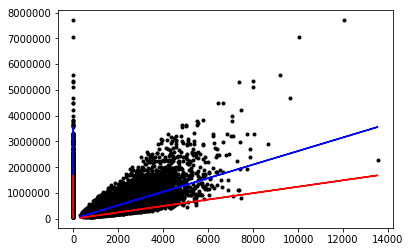

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(simple_feature_matrix,output,'k.',
         simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_0_penalty),'b-',
        simple_feature_matrix,predict_output(simple_feature_matrix, simple_weights_high_penalty),'r-')

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [ ]:
initial_predictions = predict_output(simple_test_feature_matrix, initial_weights)
initial_residuals = test_output - initial_predictions
initial_RSS = (initial_residuals **2).sum()
print initial_RSS

1784273282524564.0


In [ ]:
no_regularization_predictions = predict_output(simple_test_feature_matrix, simple_weights_0_penalty)
no_regularization_residuals = test_output - no_regularization_predictions
no_regularization_RSS = (no_regularization_residuals **2).sum()
print no_regularization_RSS

275723634597546.75


In [ ]:
regularization_predictions = predict_output(simple_test_feature_matrix, simple_weights_high_penalty)
regularization_residuals = test_output - regularization_predictions
regularization_RSS = (regularization_residuals **2).sum()
print regularization_RSS

694642100913950.1


***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?
3. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [ ]:
model_features = ['sqft_living', 'sqft_living15'] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = 'price'
(feature_matrix, output) = get_numpy_data(train_data, model_features, my_output)
(test_feature_matrix, test_output) = get_numpy_data(test_data, model_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [ ]:
initial_weights = np.array([0.0,0.0,0.0])
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [ ]:
multiple_weights_0_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 
                                                               0.0, max_iterations)
print multiple_weights_0_penalty

Starting gradient descent with l2_penalty = 0.0
Done with gradient descent at iteration  0
Learned weights =  [ -0.35743482 243.0541689   22.41481594]
[ -0.35743482 243.0541689   22.41481594]


Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [ ]:
multiple_weights_high_penalty = ridge_regression_gradient_descent(feature_matrix, output, 
                                                               initial_weights, step_size, 
                                                               1e11, max_iterations)
print multiple_weights_high_penalty

Starting gradient descent with l2_penalty = 1e+11
Done with gradient descent at iteration  0
Learned weights =  [ 6.7429658  91.48927361 78.43658768]
[ 6.7429658  91.48927361 78.43658768]


Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [ ]:
initial_predictions = predict_output(test_feature_matrix, initial_weights)
initial_residuals = test_output - initial_predictions
initial_RSS = (initial_residuals **2).sum()
print initial_RSS

1784273282524564.0


In [ ]:
no_regularization_predictions = predict_output(test_feature_matrix, multiple_weights_0_penalty)
no_regularization_residuals = test_output - no_regularization_predictions
no_regularization_RSS = (no_regularization_residuals **2).sum()
print no_regularization_RSS

274067618287245.2


In [ ]:
regularization_predictions = predict_output(test_feature_matrix, multiple_weights_high_penalty)
regularization_residuals = test_output - regularization_predictions
regularization_RSS = (regularization_residuals **2).sum()
print regularization_RSS

500404800579555.56


Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [ ]:
print no_regularization_predictions[0]
print test_output[0] - no_regularization_predictions[0]

387465.47646474396
-77465.47646474396


In [ ]:
print regularization_predictions[0]
print test_output[0] - regularization_predictions[0]

270453.5303048586
39546.46969514142


***QUIZ QUESTIONS***
1. What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?
2. What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 
3. We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?